In [1]:
import SimpleITK as sitk

#!ls /home/davapo/data/arrays/data/cztz/test/image/

path = '../picai/data/10327/10327_1000333_t2w.mha'

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Load the 3D numpy image
image = sitk.ReadImage(path)
image = sitk.GetArrayFromImage(image)
image = np.transpose(image, (1, 2, 0))

# Get the dimensions of the image
h, w, d = image.shape

def plot_slice(slice):
    plt.imshow(slice, cmap='gray')
    plt.axis('off')
    plt.show()

In [3]:
# plot all slices
# for i in range(d):
#     plt.imshow(image[:, :, i], cmap='gray')
#     plt.axis('off')
#     plt.title(f'Slice {i+1}')
#     plt.show()

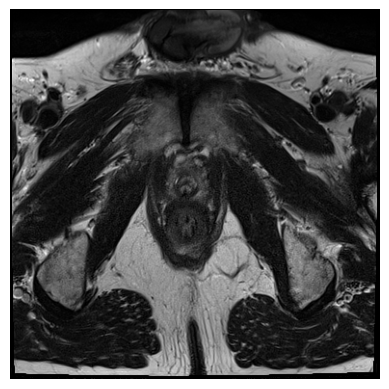

In [4]:
slice = image[:, :, 3]

plot_slice(slice)

For now we want for MRIs: 
* Inhomogeinities
* Misalignments
* Noise (already done with torch)

In [94]:
### INHOMOGEINITIES ###

from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
import cv2
from scipy.ndimage import convolve

def simulate_inhomogeneities(slice, max_artifact_px_radius=48, num_inhomogeneities=1):

    h, w = slice.shape

    # normalization to pick artifact center
    min_intensity = np.min(slice)
    max_intensity = np.max(slice)
    norm_slice = (slice - min_intensity) / (max_intensity - min_intensity)

    # Define the brightness factor
    out_factor = 1
    mask = np.full_like(slice, out_factor)

    for _ in range(num_inhomogeneities):
        pick_center = True
        region = 16
        x_center, y_center = region, region
        while (pick_center or np.mean(norm_slice[y_center-region:y_center+region, x_center-region:x_center+region]) < 0.1):
            x_center = np.random.randint(region, w - region)
            y_center = np.random.randint(region, h - region)
            pick_center = False
    
        # Ellipse area of inhomogeneity
        brightness_factor = np.random.uniform(low=1.5, high=3.5, size=1)

        # if np.random.rand() < 0.5:
        #     brightness_factor = 1/brightness_factor
        
        a, b = np.random.uniform(low=0.25, high=2, size=2)
        
        x, y = np.meshgrid(np.arange(w), np.arange(h))
    
        distance = np.sqrt(((x - x_center) / a) ** 2 + ((y - y_center) / b) ** 2)
    
        ellipse_mask = distance <= max_artifact_px_radius
        
        mask[ellipse_mask] = brightness_factor

    smoothed_mask = uniform_filter(mask, size=5)
    #smoothed_mask = gaussian_filter(mask, sigma=1.5)
    #smoothed_mask = cv2.GaussianBlur(mask, (0, 0), sigmaX=1.5, sigmaY=1.5)

    mod_slice = slice * smoothed_mask
    
    return mod_slice

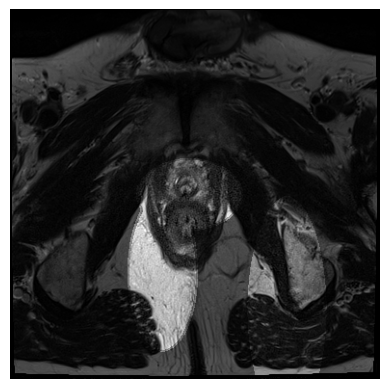

In [126]:
slice_mod = simulate_inhomogeneities(slice, max_artifact_px_radius=64, num_inhomogeneities=3)

plot_slice(slice_mod)

# plt.imshow(slice_mod, cmap='gray')
# plt.axis('off')
# plt.savefig('modified_slice.png', bbox_inches='tight', pad_inches=0.1)
# plt.show()

In [128]:
### INHOMOGEINITIES ###

from scipy.ndimage import gaussian_filter
from scipy.ndimage import uniform_filter
import cv2

def simulate_inhomogeneities_3d(volume, max_artifact_px_radius=48, num_inhomogeneities=1):

    h, w, d = volume.shape

    # normalization to pick artifact center
    min_intensity = np.min(volume)
    max_intensity = np.max(volume)
    norm_volume = (volume - min_intensity) / (max_intensity - min_intensity)

    # Define the brightness factor
    out_factor = 1
    mask = np.full_like(slice, out_factor)

    for frame in range(d):
        
        for _ in range(num_inhomogeneities):
            pick_center = True
            region = 16
            x_center, y_center = region, region
            while (pick_center or np.mean(norm_slice[y_center-region:y_center+region, x_center-region:x_center+region]) < 0.1):
                x_center = np.random.randint(region, w - region)
                y_center = np.random.randint(region, h - region)
                pick_center = False
        
            # Ellipse area of inhomogeneity
            brightness_factor = np.random.uniform(low=1.5, high=3.5, size=1)
    
            # if np.random.rand() < 0.5:
            #     brightness_factor = 1/brightness_factor
            
            a, b = np.random.uniform(low=0.25, high=2, size=2)
            
            x, y = np.meshgrid(np.arange(w), np.arange(h))
        
            distance = np.sqrt(((x - x_center) / a) ** 2 + ((y - y_center) / b) ** 2)
        
            ellipse_mask = distance <= max_artifact_px_radius
            
            mask[ellipse_mask] = brightness_factor
    
        smoothed_mask = uniform_filter(mask, size=5)
        #smoothed_mask = gaussian_filter(mask, sigma=5)
        #smoothed_mask = cv2.GaussianBlur(mask, (0, 0), sigmaX=1.5, sigmaY=1.5)
    
        mod_slice = slice * smoothed_mask
    
    return mod_slice

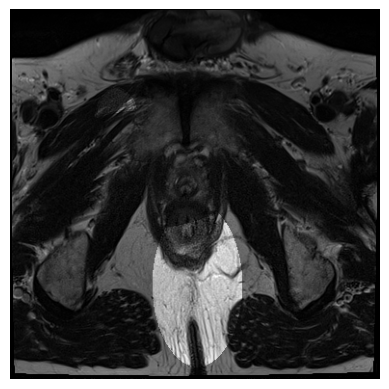

In [129]:
slice_mod = simulate_inhomogeneities_3d(slice, max_artifact_px_radius=64, num_inhomogeneities=3)

plot_slice(slice_mod)

In [88]:
### XY SHIFTS ###

import numpy as np
import random

def simulate_motion_artifacts_3d(mri_volume, shift_ratio=0.15):
    """
    Simulate motion artifacts by introducing random shifts in the MRI volume.
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
        max_shift (int): Maximum pixel shift along each axis.
    
    Returns:
        ndarray: MRI volume with simulated motion artifacts.
    """
    # Get volume dimensions
    height, width, depth = mri_volume.shape

    max_shift = int(height*shift_ratio)
    
    # Randomly generate shifts along each axis
    shift_x = random.randint(-max_shift, max_shift)
    shift_y = random.randint(-max_shift, max_shift)
    #shift_z = random.randint(-max_shift, max_shift)
    
    # Apply shifts to the MRI volume
    shifted_volume = np.roll(mri_volume, shift_x, axis=0)
    shifted_volume = np.roll(shifted_volume, shift_y, axis=1)
    #shifted_volume = np.roll(shifted_volume, shift_z, axis=2)
    
    return shifted_volume

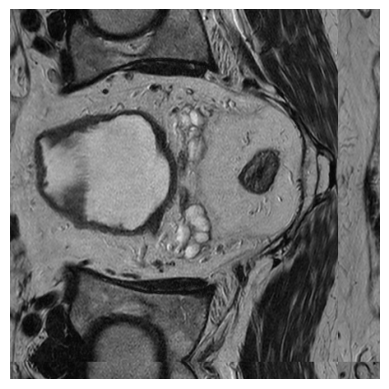

In [9]:
# we can now rotate and crop every slice and reconstruct a misaligned 3d image

image_mod = simulate_motion_artifacts(image)

plot_slice(image_mod[:, :, 6])

In [491]:
def simulate_motion_artifacts(slice, shift_ratio=0.15):
    # Get volume dimensions
    height, width = slice.shape

    max_shift = int(height*shift_ratio)
    
    # Randomly generate shifts along each axis
    shift_x = np.random.randint(-max_shift, max_shift)
    shift_y = np.random.randint(-max_shift, max_shift)
    #shift_z = random.randint(-max_shift, max_shift)
    
    # Apply shifts to the MRI volume
    shifted_slice = np.roll(slice, shift_x, axis=0)
    shifted_slice = np.roll(slice, shift_y, axis=1)
    #shifted_volume = np.roll(shifted_volume, shift_z, axis=2)
    
    return shifted_slice

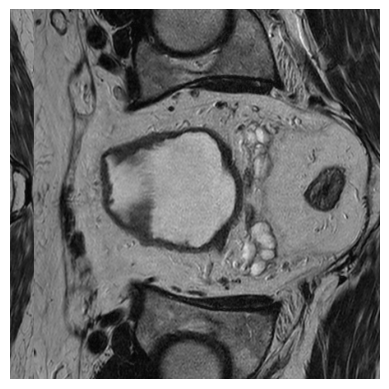

In [492]:
slice_mod = simulate_motion_artifacts(slice)

plot_slice(slice_mod)

In [66]:
### BLURRING GHOSTING IN MOTION ###

import numpy as np
import random
from scipy.ndimage import convolve

def simulate_blurring_ghosting_3d(mri_volume, blur_strength=1):
    """
    Simulate blurring or ghosting effects by convolving the MRI volume with a blurring kernel.
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
        kernel_size (int): Size of the blurring kernel.
        blur_strength (float): Strength of the blurring effect.
    
    Returns:
        ndarray: MRI volume with simulated blurring or ghosting effects.
        
    """

    blur_strength = np.random.uniform(low=1, high=3)
    kx, ky, kz = np.random.randint(low=1.5, high=4, size=3)

    # Generate blurring kernel
    kernel = np.ones((kx, ky, kz)) / (kx*ky*kz)
    
    # Apply convolution to simulate blurring or ghosting
    blurred_volume = convolve(mri_volume, kernel)
    
    # Add blurred volume to original volume with reduced intensity
    simulated_volume = mri_volume + blur_strength * (blurred_volume - mri_volume)
    
    return simulated_volume


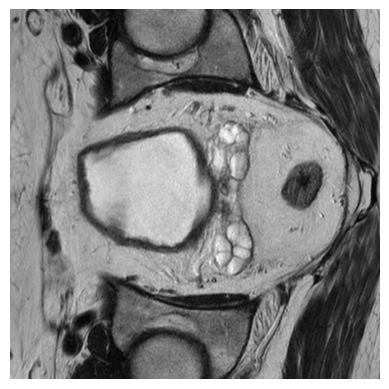

In [22]:
# we can now rotate and crop every slice and reconstruct a misaligned 3d image

image_mod = simulate_blurring_ghosting_3d(image)

plot_slice(image_mod[:, :, 6])

In [67]:
def simulate_blurring_ghosting(slice, blur_strength=1):
    """
    Simulate blurring or ghosting effects by convolving the MRI volume with a blurring kernel.
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
        kernel_size (int): Size of the blurring kernel.
        blur_strength (float): Strength of the blurring effect.
    
    Returns:
        ndarray: MRI volume with simulated blurring or ghosting effects.
        
    """

    blur_strength = np.random.uniform(low=1, high=3)
    kx, ky = np.random.randint(low=1.5, high=5, size=2)

    # Generate blurring kernel
    kernel = np.ones((kx, ky)) / (kx*ky)
    
    # Apply convolution to simulate blurring or ghosting
    mod_slice = convolve(slice, kernel)
    
    # Add blurred volume to original volume with reduced intensity
    mod_slice = blur_strength * mod_slice + (1 - blur_strength) * (slice)
    
    return mod_slice

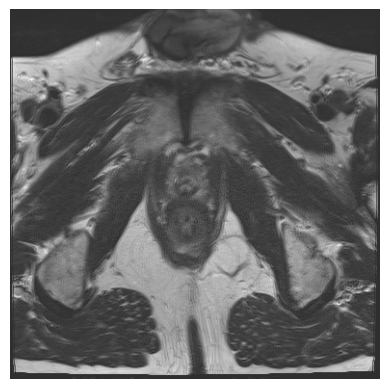

In [72]:
# we can now rotate and crop every slice and reconstruct a misaligned 3d image

slice_mod = simulate_blurring_ghosting(slice)

plot_slice(slice_mod)

In [483]:
### ALISING ###
# To simulate undersampling

import numpy as np
from scipy.ndimage import zoom

def simulate_aliasing(mri_volume, undersample_factor=2, interpolation='nearest'):
    """
    Simulate aliasing effects by downsampling and then upsampling the MRI volume.
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
        undersample_factor (int): Factor by which to downscale the volume.
        interpolation (str): Interpolation method to use during upsampling.
            Options: 'nearest', 'linear', 'cubic'
    
    Returns:
        ndarray: MRI volume with simulated aliasing effects.
    """
    undersample_factor = np.random.uniform(low=1, high=3)
    
    # Downsample the volume
    downsampled_volume = zoom(mri_volume, 1/undersample_factor, order=1)
    
    # Upsample the downsampled volume
    simulated_volume = zoom(downsampled_volume, undersample_factor, order=1, mode='wrap', prefilter=False)
    
    return simulated_volume

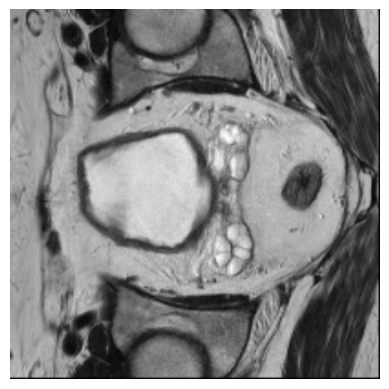

In [484]:
image_mod = simulate_aliasing(image)

plot_slice(image_mod[:, :, 7])

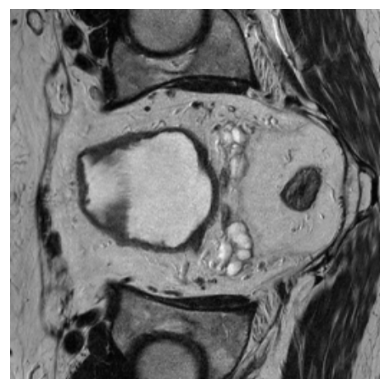

In [485]:
slice_mod = simulate_aliasing(slice)

plot_slice(slice_mod)

In [440]:
### GRADIENT NONLINEARITY ###
from scipy.interpolate import RegularGridInterpolator

def simulate_gradient_nonlinearity(mri_volume, p=0.5):
    """
    Simulate gradient nonlinearity effects by applying spatially varying deformations to the MRI volume.
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
        distortion_factor (float): Factor controlling the strength of the distortion.
    
    Returns:
        ndarray: MRI volume with simulated gradient nonlinearity effects.
    """

    # it could be done to 3d if we want to
    
    # Generate distorted coordinates
    amp_distortion_x = np.random.uniform(low=0.1, high=2)
    amp_distortion_y = np.random.uniform(low=0.1, high=2)
    distortion_factor_x = np.random.uniform(low=0.1, high=1.25)
    distortion_factor_y = np.random.uniform(low=0.1, high=1.25)
    
    x, y, z = np.indices(mri_volume.shape, dtype=float)
    distorted_x = x + distortion_factor_x * np.sin(amp_distortion_x*y)
    distorted_y = y + distortion_factor_y * np.sin(amp_distortion_y*x)
    
    # Interpolate the distorted volume
    distorted_volume = np.zeros_like(mri_volume)
    for i in range(mri_volume.shape[2]):
            
        if np.random.uniform() < p:
            interpolator = RegularGridInterpolator((np.arange(mri_volume.shape[0]),
                                                    np.arange(mri_volume.shape[1])),
                                                   mri_volume[:, :, i],
                                                   bounds_error=False,
                                                   fill_value=0)
            distorted_volume[:, :, i] = interpolator((distorted_x[:, :, i], distorted_y[:, :, i]))
        else:
            distorted_volume[:, :, i] = mri_volume[:, :, i]
    
    return distorted_volume

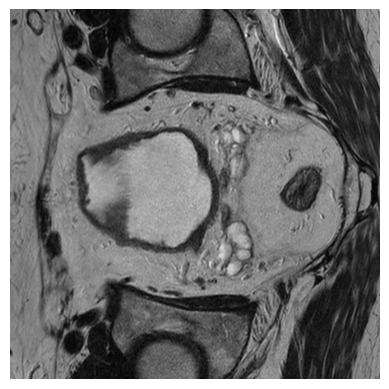

In [441]:
image_mod = simulate_gradient_nonlinearity(image)

plot_slice(image_mod[:, :, 6])

In [493]:
### GRADIENT NONLINEARITY ###
from scipy.interpolate import RegularGridInterpolator

def simulate_gradient_nonlinearity(slice):
    """
    Simulate gradient nonlinearity effects by applying spatially varying deformations to the MRI volume.
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
        distortion_factor (float): Factor controlling the strength of the distortion.
    
    Returns:
        ndarray: MRI volume with simulated gradient nonlinearity effects.
    """

    # it could be done to 3d if we want to
    
    # Generate distorted coordinates
    amp_distortion_x = np.random.uniform(low=0.1, high=2)
    amp_distortion_y = np.random.uniform(low=0.1, high=2)
    distortion_factor_x = np.random.uniform(low=0.1, high=1.25)
    distortion_factor_y = np.random.uniform(low=0.1, high=1.25)
    
    x, y = np.indices(slice.shape, dtype=float)
    distorted_x = x + distortion_factor_x * np.sin(amp_distortion_x*y)
    distorted_y = y + distortion_factor_y * np.sin(amp_distortion_y*x)
    
    # Interpolate the distorted volume
    distorted_slice = np.zeros_like(slice)

    interpolator = RegularGridInterpolator((np.arange(slice.shape[0]),
                                            np.arange(slice.shape[1])),
                                           slice,
                                           bounds_error=False,
                                           fill_value=0)
    distorted_slice = interpolator((distorted_x, distorted_y))

    return distorted_slice

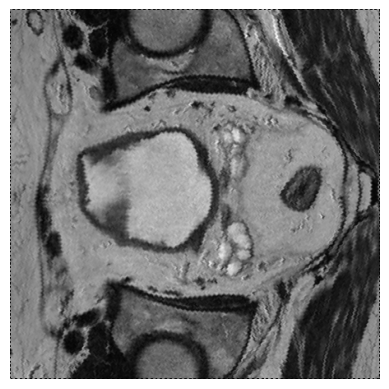

In [497]:
slice_mod = simulate_gradient_nonlinearity(slice)

plot_slice(slice_mod)

In [442]:
import numpy as np

def simulate_susceptibility_artifacts(mri_volume, artifact_density=0.1, artifact_intensity=500, p=0.5):
    """
    Simulate susceptibility artifacts by introducing signal voids or distortions in the MRI volume.
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
        artifact_density (float): Density of susceptibility artifacts (percentage of affected voxels).
        artifact_intensity (float): Intensity of the artifacts (typically negative values for signal voids).
    
    Returns:
        ndarray: MRI volume with simulated susceptibility artifacts.
    """
    artifact_density = np.random.uniform(low=0.02, high=0.12)
    artifact_intensity = np.random.uniform(low=1, high=300)
    
    # Determine the number of affected voxel
    num_affected_voxels = int(artifact_density * mri_volume.size)
    
    # Randomly select voxels to be affected
    affected_indices = np.random.choice(mri_volume.size, num_affected_voxels, replace=False)
    
    # Introduce susceptibility artifacts
    mri_volume_with_artifacts = mri_volume.copy()
    mri_volume_with_artifacts.flat[affected_indices] = artifact_intensity

    for idx in range(mri_volume.shape[2]):
        if np.random.uniform() > p:
            mri_volume_with_artifacts[:,:,idx] = mri_volume[:,:,idx]
    
    return mri_volume_with_artifacts


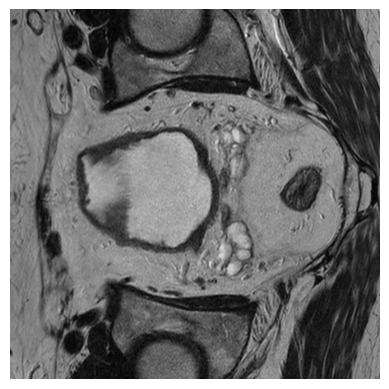

In [443]:
image_mod = simulate_susceptibility_artifacts(image)

plot_slice(image_mod[:, :, 6])

In [444]:
import numpy as np
from scipy.ndimage import gaussian_filter

def simulate_partial_volume_effect_3d(mri_volume, sigma=1.0, p=0.5):
    """
    Simulate partial volume effects by convolving the MRI volume with a Gaussian point spread function (PSF).
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
        sigma (float): Standard deviation of the Gaussian PSF, controlling the amount of blurring.
    
    Returns:
        ndarray: MRI volume with simulated partial volume effects.
    """
    sigma = np.random.uniform(low=0.1, high=0.8)
    
    # Apply Gaussian blurring to simulate partial volume effects
    blurred_volume = gaussian_filter(mri_volume, sigma=sigma)

    for idx in range(mri_volume.shape[2]):
        if np.random.uniform() > p:
            blurred_volume[:,:,idx] = mri_volume[:,:,idx]
    
    return blurred_volume


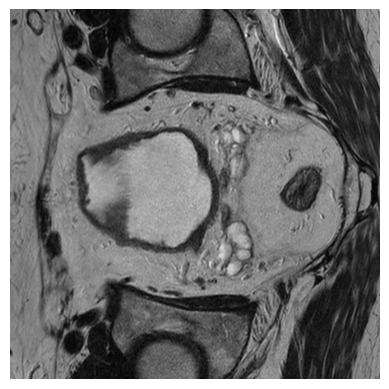

In [102]:
image_mod = simulate_partial_volume_effect(image)

plot_slice(image_mod[:, :, 6])

In [531]:
import numpy as np
from scipy.ndimage import gaussian_filter

def simulate_partial_volume_effect(img, sigma=1.0):
    """
    Simulate partial volume effects by convolving the MRI volume with a Gaussian point spread function (PSF).
    
    Parameters:
        image (ndarray): numpy array
        sigma (float): Standard deviation of the Gaussian PSF, controlling the amount of blurring.
    
    Returns:
        ndarray: MRI volume with simulated partial volume effects.
    """
    sigma = np.random.uniform(low=0.5, high=2)
    
    blurred_img = gaussian_filter(img, sigma=sigma)
    
    return blurred_img

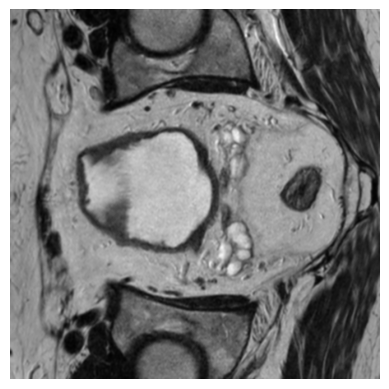

In [536]:
slice_mod = simulate_partial_volume_effect(slice)

plot_slice(slice_mod)

In [540]:
import numpy as np

def simulate_ghosting_3d(mri_volume, ghosting_factor=0.12, p=0.33):
    """
    Simulate ghosting artifacts by introducing duplicated images shifted along the phase-encoding direction.
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
        ghosting_factor (float): Factor controlling the strength of the ghosting artifacts.
    
    Returns:
        ndarray: MRI volume with simulated ghosting artifacts.
    """
    ghosting_shifts = np.random.uniform(low=0.1, high=0.2)
    ghosting_intensity = np.random.uniform(low=0.05, high=0.5)
    
    # Determine the number of shifted copies
    num_shifts = int(ghosting_shifts * mri_volume.shape[2])
    
    # Generate shifted copies
    ghosted_volume = np.zeros_like(mri_volume)
    for shift in range(1, num_shifts + 1):
        ghosted_volume[:,:,:-shift] += ghosting_intensity*mri_volume[:,:,shift:]
    # Combine with the original volume
    ghosted_volume += mri_volume

    for idx in range(mri_volume.shape[2]):
        if np.random.uniform() > p:
            ghosted_volume[:,:,idx] = mri_volume[:,:,idx]
    
    return ghosted_volume


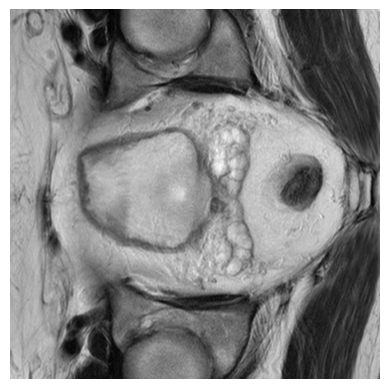

In [547]:
image_mod = simulate_ghosting_3d(image)

plot_slice(image_mod[:, :, 6])

In [548]:
def add_gaussian_noise_3d(mri_volume, mean_factor=0.5, std_factor=0.1, p=0.5):
    """
    Add Gaussian noise to the MRI volume.
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
        mean (float): Mean of the Gaussian distribution (default: 0).
        std (float): Standard deviation of the Gaussian distribution (default: 1).
    
    Returns:
        ndarray: MRI volume with added Gaussian noise.
    """
    
    mean_factor = np.random.uniform(low=0.1, high=1)
    std_factor = np.random.uniform(low=0.1, high=0.6)
    
    # Generate Gaussian noise with the same shape as the MRI volume
    noise = np.random.normal(mri_volume.mean(), std_factor*mri_volume.std(), mri_volume.shape)
    
    # Add the noise to the MRI volume
    noisy_volume = mri_volume + noise

    for idx in range(mri_volume.shape[2]):
        if np.random.uniform() > p:
            noisy_volume[:,:,idx] = mri_volume[:,:,idx]
    
    return noisy_volume


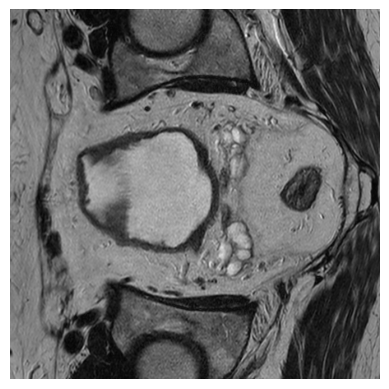

In [550]:
image_mod = add_gaussian_noise_3d(image, p=0.2)

plot_slice(image_mod[:, :, 6])

In [551]:
def add_gaussian_noise(image, mean_factor=0.5, std_factor=0.1):
    mean_factor = np.random.uniform(low=0.1, high=1)
    std_factor = np.random.uniform(low=0.1, high=0.6)
    
    # Generate Gaussian noise with the same shape as the MRI volume
    noise = np.random.normal(image.mean(), std_factor*image.std(), image.shape)
    
    # Add the noise to the MRI volume
    noisy_img = image + noise

    return noisy_img


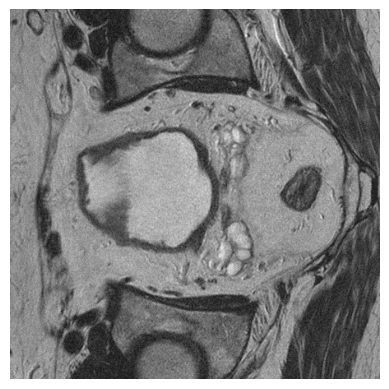

In [555]:
slice_mod = add_gaussian_noise(slice)

plot_slice(slice_mod)

In [557]:
import numpy as np

def simulate_axis_ghosting_3d(mri_volume, grid_value=13, ratio=2):
    """
    Simulate vertical ghosting artifact by summing one cell to the rest of the cells in the same column.
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
    
    Returns:
        ndarray: MRI volume with simulated vertical ghosting artifact.
    """
    grid_value_x = np.random.randint(2, 16)
    grid_value_y = np.random.randint(2, 16)
    intensity_factor = np.random.uniform(low=0.25, high=0.75)
    blur_factor = np.random.uniform(low=0.1, high=2)
    
    # Get the dimensions of the MRI volume
    width, height, num_slices = mri_volume.shape
    mri_volume_tmp = mri_volume.copy()
    
    # Define the grid size
    grid_width = width//grid_value_x
    grid_height = height//grid_value_y

    # Randomly pick the i,j coordinate for the chosen cell
    selected_i = np.random.randint(grid_value_x-1)
    selected_j = np.random.randint(grid_value_y-1)
    selected_slice = np.random.randint(num_slices)
    #selected_slice = 6
    
    cell = mri_volume[int(selected_i*grid_width):int((selected_i+1)*grid_width),
                        int(selected_j*grid_height):int((selected_j+1)*grid_height),selected_slice]

    cell = gaussian_filter(cell, sigma=blur_factor)
    
    if np.random.uniform() < 0.5:
        for idx in range(grid_value_y):
            if idx != selected_j:
                mri_volume_tmp[int(selected_i*grid_width):int((selected_i+1)*grid_width),
                                int(idx*grid_height):int((idx+1)*grid_height),selected_slice] *= 1-intensity_factor
                mri_volume_tmp[int(selected_i*grid_width):int((selected_i+1)*grid_width),
                                int(idx*grid_height):int((idx+1)*grid_height),selected_slice] += intensity_factor*cell
    else:
        for idx in range(grid_value_x):
            if idx != selected_i:
                mri_volume_tmp[int(idx*grid_width):int((idx+1)*grid_width),
                                int(selected_j*grid_height):int((selected_j+1)*grid_height),selected_slice] *= 1-intensity_factor
                mri_volume_tmp[int(idx*grid_width):int((idx+1)*grid_width),
                                int(selected_j*grid_height):int((selected_j+1)*grid_height),selected_slice] += intensity_factor*cell

    return mri_volume_tmp


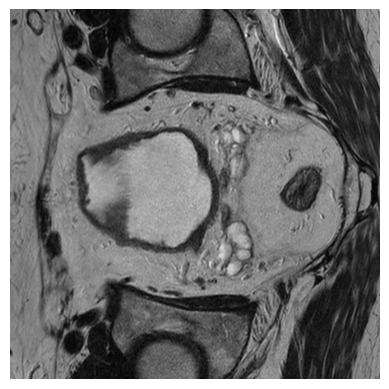

In [558]:
image_mod = simulate_axis_ghosting_3d(image)

plot_slice(image_mod[:, :, 6])

In [565]:
import numpy as np

def simulate_axis_ghosting(mri_volume, grid_value=13, ratio=2):
    """
    Simulate vertical ghosting artifact by summing one cell to the rest of the cells in the same column.
    
    Parameters:
        mri_volume (ndarray): 3D numpy array representing the MRI volume.
    
    Returns:
        ndarray: MRI volume with simulated vertical ghosting artifact.
    """
    grid_value_x = np.random.randint(2, 16)
    grid_value_y = np.random.randint(2, 16)
    intensity_factor = np.random.uniform(low=0.25, high=0.75)
    blur_factor = np.random.uniform(low=0.1, high=2)
    
    # Get the dimensions of the MRI volume
    width, height = mri_volume.shape
    mri_volume_tmp = mri_volume.copy()
    
    # Define the grid size
    grid_width = width//grid_value_x
    grid_height = height//grid_value_y

    # Randomly pick the i,j coordinate for the chosen cell
    selected_i = np.random.randint(grid_value_x-1)
    selected_j = np.random.randint(grid_value_y-1)
    
    cell = mri_volume[int(selected_i*grid_width):int((selected_i+1)*grid_width),
                        int(selected_j*grid_height):int((selected_j+1)*grid_height)]

    cell = gaussian_filter(cell, sigma=blur_factor)
    
    if np.random.uniform() < 0.5:
        for idx in range(grid_value_y):
            if idx != selected_j:
                mri_volume_tmp[int(selected_i*grid_width):int((selected_i+1)*grid_width),
                                int(idx*grid_height):int((idx+1)*grid_height)] *= 1-intensity_factor
                mri_volume_tmp[int(selected_i*grid_width):int((selected_i+1)*grid_width),
                                int(idx*grid_height):int((idx+1)*grid_height)] += intensity_factor*cell
    else:
        for idx in range(grid_value_x):
            if idx != selected_i:
                mri_volume_tmp[int(idx*grid_width):int((idx+1)*grid_width),
                                int(selected_j*grid_height):int((selected_j+1)*grid_height)] *= 1-intensity_factor
                mri_volume_tmp[int(idx*grid_width):int((idx+1)*grid_width),
                                int(selected_j*grid_height):int((selected_j+1)*grid_height)] += intensity_factor*cell

    return mri_volume_tmp


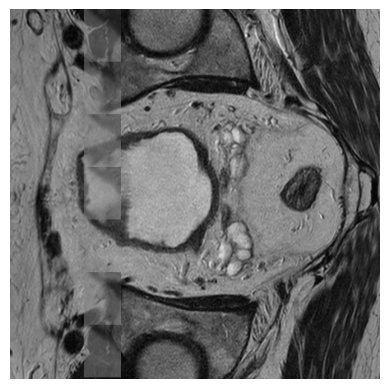

In [594]:
slice_mod = simulate_axis_ghosting(slice)

plot_slice(slice_mod)

In [29]:
### MISALIGNMENTS ###

from scipy.ndimage import rotate

def center_crop(image, crop_ratio=0.80):

    crop_h = int(h * crop_ratio)
    crop_w = int(w * crop_ratio)
    start_h = (h - crop_h) // 2
    start_w = (w - crop_w) // 2

    return image[start_h:start_h+crop_h, start_w:start_w+crop_w]

def rotate_and_crop(image, angle=-15, crop_ratio=0.80):

    # Rotate the image and center crop
    image = rotate(image, angle=angle, axes=(0, 1), reshape=False, mode='constant')

    return center_crop(image, crop_ratio=0.80)

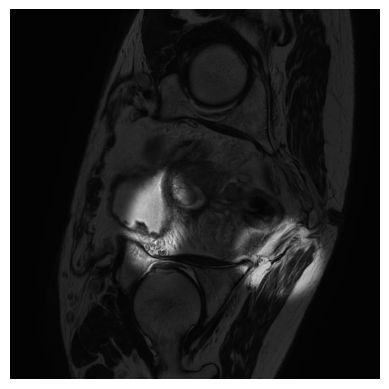

In [7]:
slice_rot = rotate_and_crop(slice_mod)

plot_slice(slice_rot)

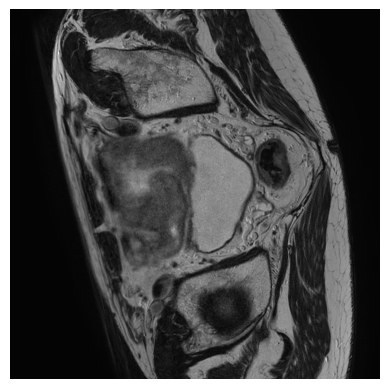

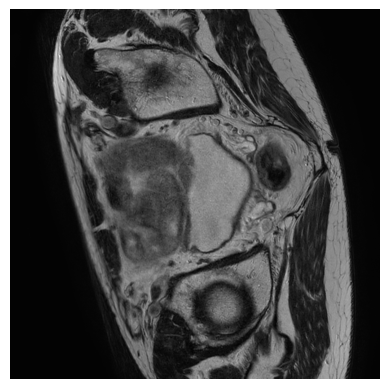

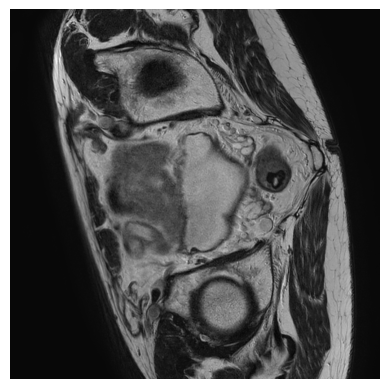

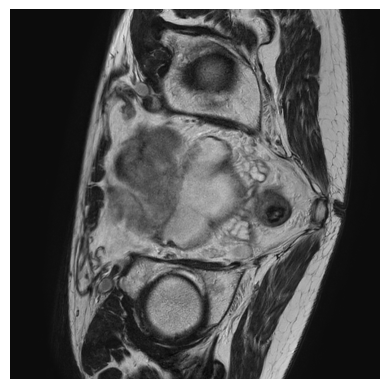

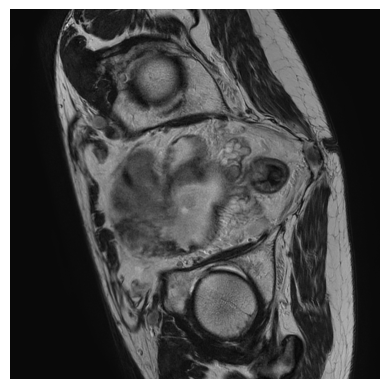

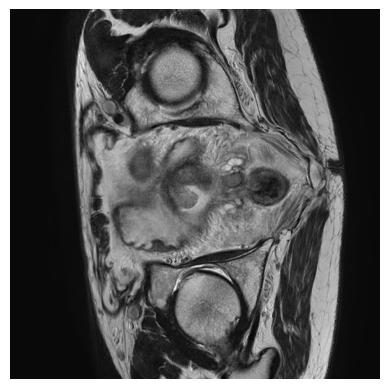

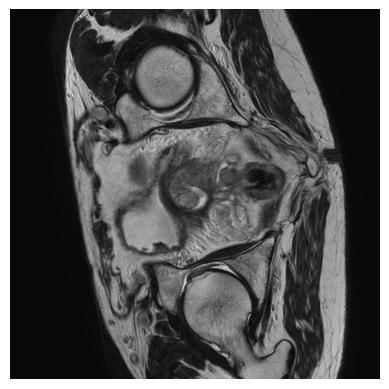

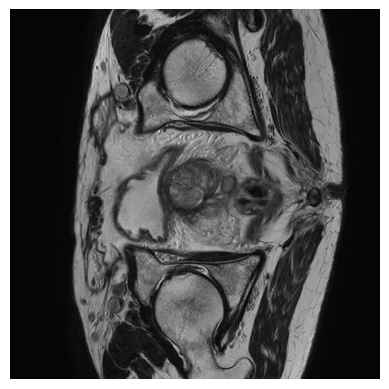

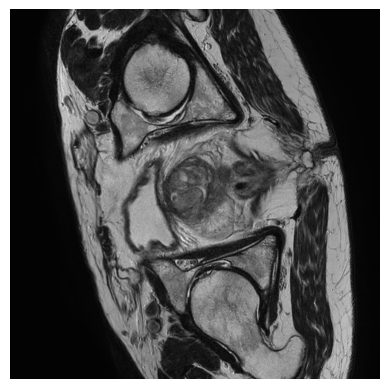

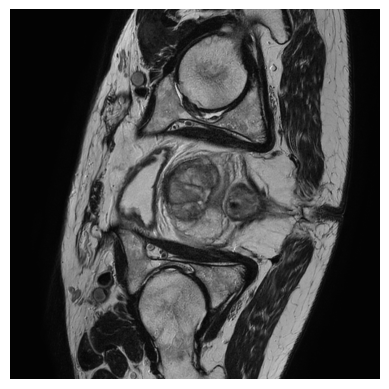

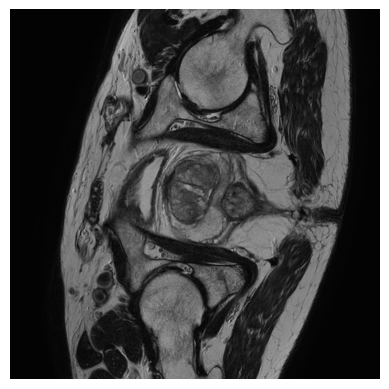

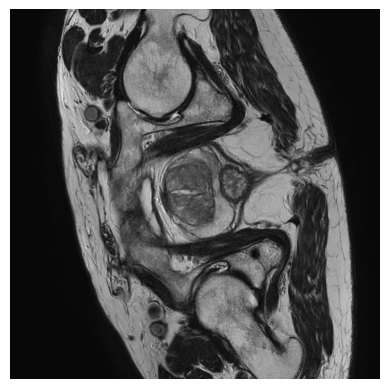

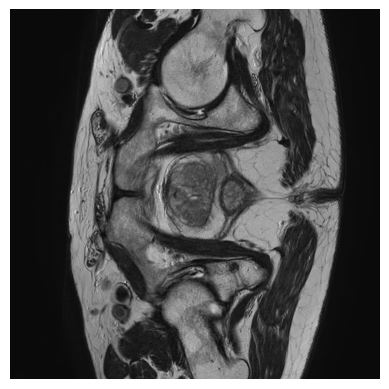

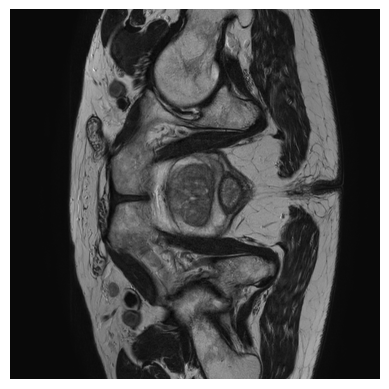

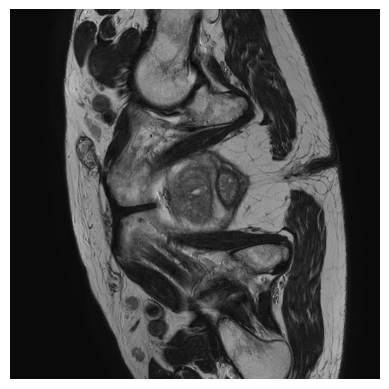

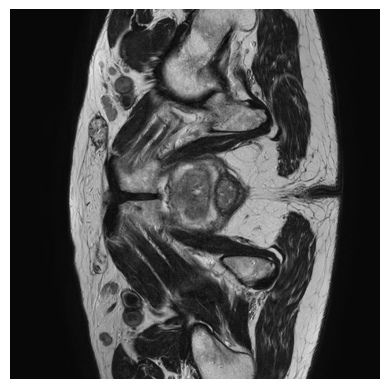

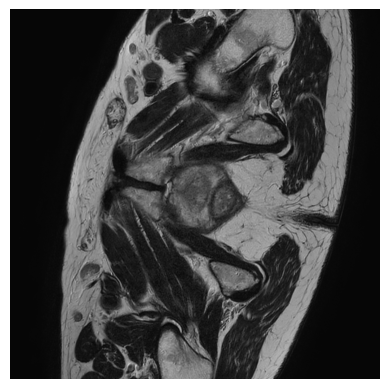

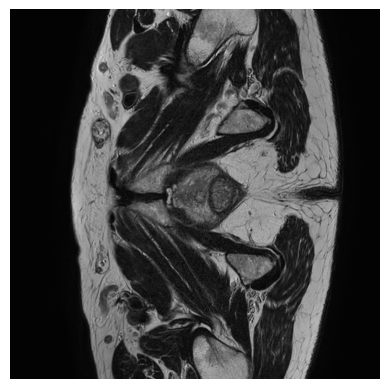

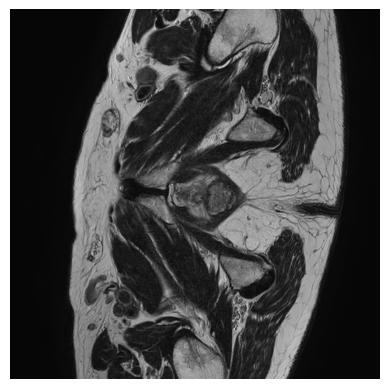

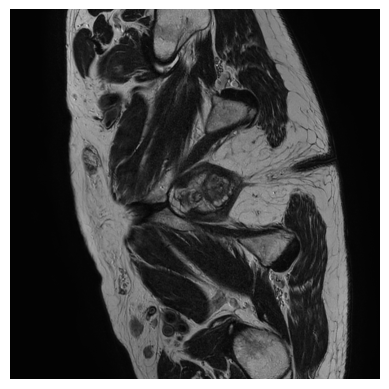

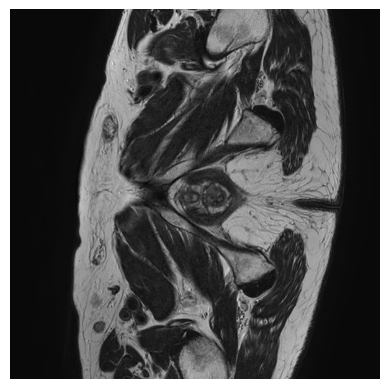

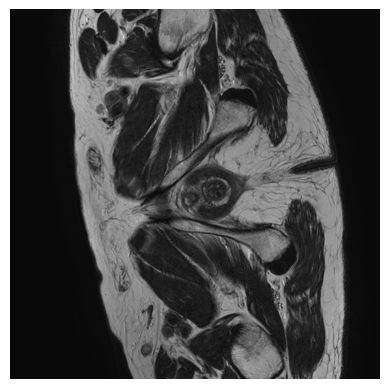

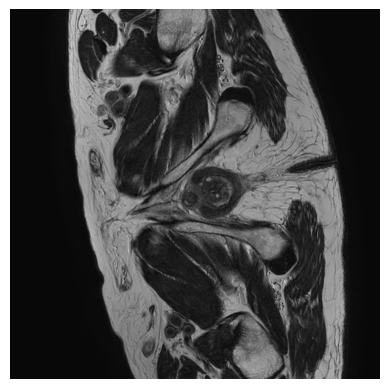

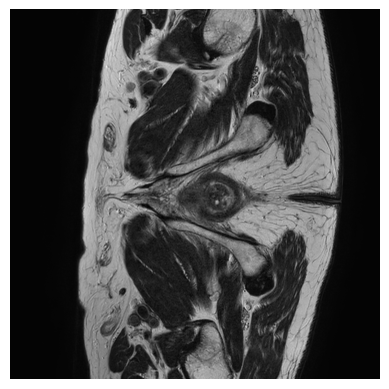

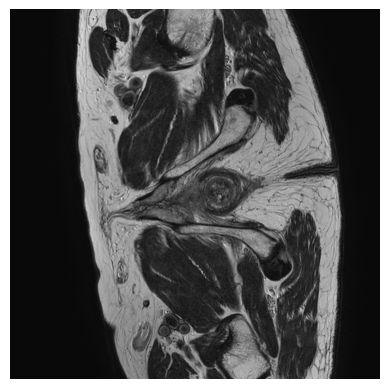

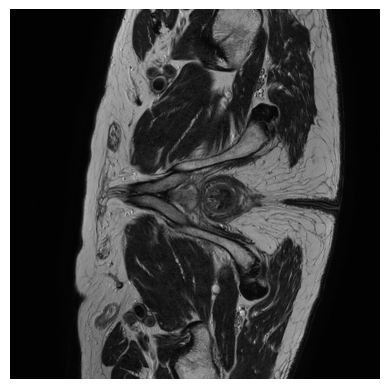

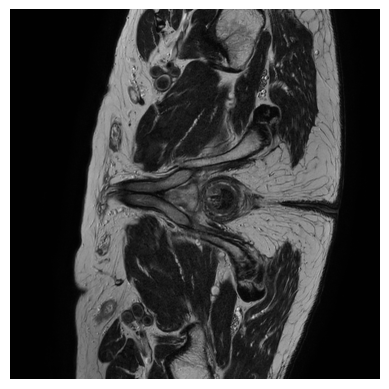

In [8]:
crop_ratio = 0.80

h,w,d = image.shape

# Initialize an empty array
rotated_image = np.zeros((int(h*crop_ratio), int(w*crop_ratio), d))

# Iterate over each slice of the 3D image
for i in range(d):
    slice = image[:, :, i]

    angle = np.random.uniform(-15,15)
    
    rotated_image[:, :, i] = rotate_and_crop(slice, angle=angle, crop_ratio=crop_ratio)

    plot_slice(rotated_image[:, :, i])